In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# mandelbrot

> An implementation of the Mandelbrot set.

In [ ]:
#| default_exp fractal.mandelbrot

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from numba import njit, prange
import math
from fractalart.fractal.abstract_fractal import Fractal

In [ ]:
#| export
@njit(parallel=True, fastmath=True)
def _compute_mandelbrot(x_min: float, x_max: float, y_min: float, y_max: float, resolution: tuple[int, int],
                     max_iter: int, fractal_fn, order: int = 1, smooth: bool = True) -> np.ndarray:
    
    width, height = resolution
    result = np.zeros((height, width), dtype=np.float64)
    #r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))

    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)
    inv_log2 = 1.0 / math.log(2.0)

    for j in prange(height):
        zy = y_min + j * dy
        for i in range(width):
            zx = x_min + i * dx
            zr = 0.0
            zi = 0.0
            cr = zx
            ci = zy
            iteration = 0

            #while zr * zr + zi * zi <= r2_cut and iteration < max_iter:
            while zr * zr + zi * zi <= 4.0 and iteration < max_iter:
                zr, zi = fractal_fn(zr, zi, cr, ci, order)
                iteration += 1

            if smooth and iteration < max_iter:
                result[j, i] = smooth_coloring(zr, zi, iteration)
            else:
                result[j, i] = iteration

    return result

In [ ]:
#| export
_inv_log2 = 1.0 / math.log(2.0)

@njit
def smooth_coloring(zr, zi, iteration):
    mag_sq = zr * zr + zi * zi

    # Ensure mag_sq > 1 to avoid log(≤0)
    if mag_sq > 1e-8:
        log_zn = 0.5 * math.log(mag_sq)
        if log_zn > 1e-8:
            nu = math.log(log_zn * _inv_log2) * _inv_log2
            return iteration + 1 - nu

    return float(iteration)

@njit
def mandelbrot_step_1(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr_new = zr2 - zi2 + cr
    zi_new = 2.0 * zr * zi + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_3(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr3 = zr2 * zr
    zi3 = zi2 * zi
    zr_new = zr3 - 3.0 * zr * zi2 + cr
    zi_new = 3.0 * zr2 * zi - zi3 + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_4(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr4 = zr2 * zr2
    zi4 = zi2 * zi2
    zr2zi2 = zr2 * zi2
    zr_new = zr4 - 6.0 * zr2zi2 + zi4 + cr
    zi_new = 4.0 * zr * zi * (zr2 - zi2) + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_5(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr3 = zr2 * zr
    zi3 = zi2 * zi
    zr4 = zr3 * zr
    zi4 = zi3 * zi
    zr5 = zr4 * zr
    zi5 = zi4 * zi
    zrzi = zr * zi
    zrzi3 = zrzi * zi2  # zr * zi^3
    zr3zi = zr3 * zi    # zr^3 * zi
    zrzi3 = zr * zi3    # zr * zi^3
    zr_new = zr5 - 10.0 * zr3 * zi2 + 5.0 * zr * zi4 + cr
    zi_new = 5.0 * zr4 * zi - 10.0 * zr2 * zi3 + zi5 + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_n(zr, zi, cr, ci, n):
    z = complex(zr, zi)
    c = complex(cr, ci)
    z = z ** n + c
    return z.real, z.imag

@njit
def mandelbrot_step(zr, zi, cr, ci, n):
    if n == 2:
        return mandelbrot_step_1(zr, zi, cr, ci)
    elif n == 3:
        return mandelbrot_step_3(zr, zi, cr, ci)
    elif n == 4:
        return mandelbrot_step_4(zr, zi, cr, ci)
    elif n == 5:
        return mandelbrot_step_5(zr, zi, cr, ci)
    else:
        return mandelbrot_step_n(zr, zi, cr, ci, n)

In [ ]:
#| export
class Mandelbrot(Fractal):
    def __init__(
        self,
        x_min: float = None,
        x_max: float = None,
        y_min: float = None,
        y_max: float = None,
        width: int = 600,
        height: int = 600,
        max_iter: int = 200,
        order: int = 2
    ):
        """Initialize the fractal with image resolution and complex plane bounds."""
        self._order = order
        if None in (x_min, x_max, y_min, y_max):
            if order == 2:
                x_min, x_max, y_min, y_max = -2.5, 1.5, -2.0, 2.0
            else:
                x_min, x_max, y_min, y_max = -1.8, 1.8, -1.8, 1.8
        self._x_min, self._x_max = x_min, x_max
        self._y_min, self._y_max = y_min, y_max
        self.resolution = width, height
        self.max_iter = max_iter
        
    def compute(self) -> np.ndarray:
        return _compute_mandelbrot(self._x_min, self._x_max, self._y_min, self._y_max,
                                self.resolution, self._max_iter, mandelbrot_step, self._order)

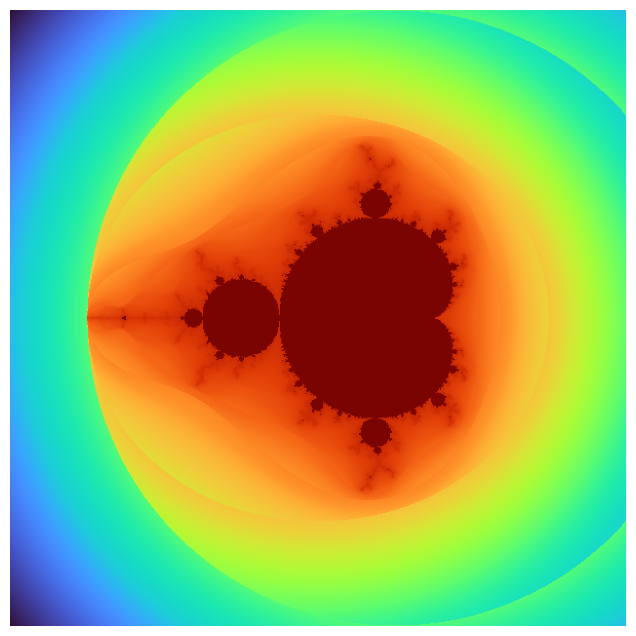

In [ ]:
m = Mandelbrot()
a = m.render()
m.equalize_histogram()
m.plot()

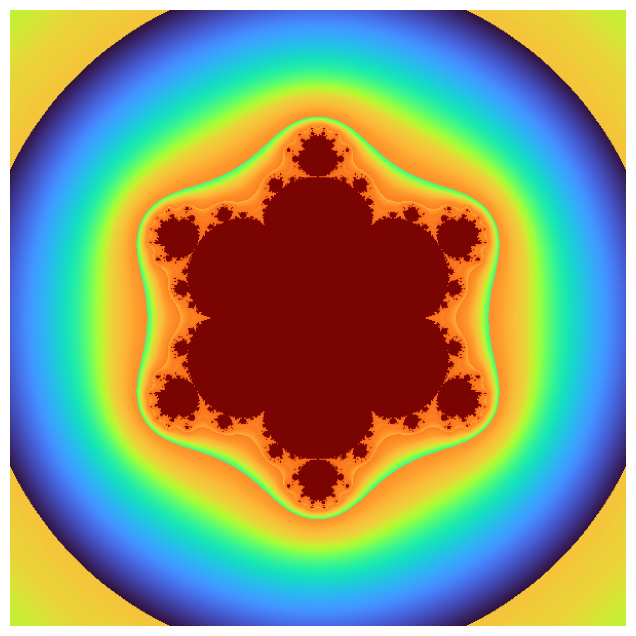

In [ ]:
m = Mandelbrot(order=7)
a = m.render()
m.equalize_histogram()
m.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()